In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/core-dataset/cora.cites
/kaggle/input/core-dataset/cora.content


In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
content = pd.read_csv("/kaggle/input/core-dataset/cora.content", sep="\t", header=None)

# Separate features and labels
features = content.iloc[:, 1:-1]
labels = content.iloc[:, -1]
paper_ids = content.iloc[:, 0]

print("Content file shape:", content.shape)
print("Number of features:", features.shape[1])
print("Unique classes:", labels.unique())
print(content.head())

Content file shape: (2708, 1435)
Number of features: 1433
Unique classes: ['Neural_Networks' 'Rule_Learning' 'Reinforcement_Learning'
 'Probabilistic_Methods' 'Theory' 'Genetic_Algorithms' 'Case_Based']
      0     1     2     3     4     5     6     7     8     9     ...  1425  \
0    31336     0     0     0     0     0     0     0     0     0  ...     0   
1  1061127     0     0     0     0     0     0     0     0     0  ...     0   
2  1106406     0     0     0     0     0     0     0     0     0  ...     0   
3    13195     0     0     0     0     0     0     0     0     0  ...     0   
4    37879     0     0     0     0     0     0     0     0     0  ...     0   

   1426  1427  1428  1429  1430  1431  1432  1433                    1434  
0     0     1     0     0     0     0     0     0         Neural_Networks  
1     1     0     0     0     0     0     0     0           Rule_Learning  
2     0     0     0     0     0     0     0     0  Reinforcement_Learning  
3     0     0     

In [19]:
edges = pd.read_csv("/kaggle/input/core-dataset/cora.cites", sep="\t", header=None, names=["source", "target"])
print("Edges file shape:", edges.shape)
G = nx.from_pandas_edgelist(edges, source="source", target="target", create_using=nx.DiGraph())
G = G.subgraph(paper_ids).copy()
print("Graph info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")
print(edges.head())


Edges file shape: (5429, 2)
Graph info:
Number of nodes: 2708
Number of edges: 5429
Is directed: True
   source   target
0      35     1033
1      35   103482
2      35   103515
3      35  1050679
4      35  1103960


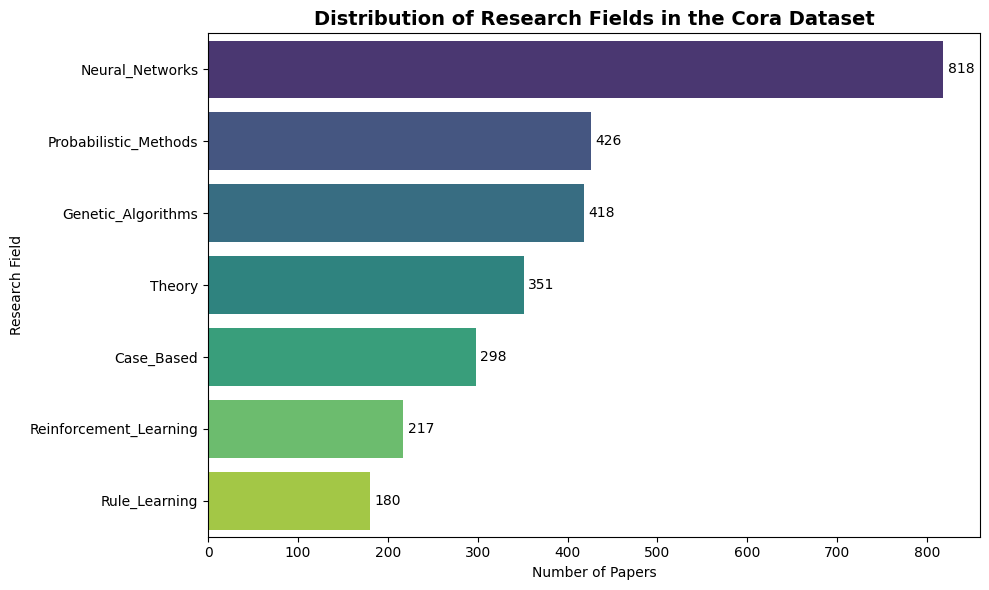

In [20]:
# Extract labels (classes)
labels = content.iloc[:, -1]

# Create a DataFrame for plotting
class_counts = labels.value_counts().reset_index()
class_counts.columns = ["Class", "Count"]

# Set plot style
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Class", data=class_counts, palette="viridis")

# Add titles and labels
plt.title("Distribution of Research Fields in the Cora Dataset", fontsize=14, weight='bold')
plt.xlabel("Number of Papers")
plt.ylabel("Research Field")

# Annotate bars
for i, v in enumerate(class_counts["Count"]):
    plt.text(v + 5, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [21]:
import plotly.graph_objects as go
import networkx as nx

# Use spring layout in 3D space
pos = nx.spring_layout(G, dim=3, seed=42)

x_nodes = [pos[k][0] for k in G.nodes()]
y_nodes = [pos[k][1] for k in G.nodes()]
z_nodes = [pos[k][2] for k in G.nodes()]

x_edges = []
y_edges = []
z_edges = []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]
    z_edges += [pos[edge[0]][2], pos[edge[1]][2], None]

edge_trace = go.Scatter3d(
    x=x_edges, y=y_edges, z=z_edges,
    mode='lines', line=dict(color='black', width=1), hoverinfo='none'
)

node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers', marker=dict(symbol='circle', size=5, color='darkblue'),
    hoverinfo='none'
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title='3D Cora Citation Graph',
    showlegend=False, scene=dict(xaxis=dict(visible=False),
                                 yaxis=dict(visible=False),
                                 zaxis=dict(visible=False)),
    width=900, height=700,
    paper_bgcolor='white', scene_bgcolor='white'
)
fig.show()


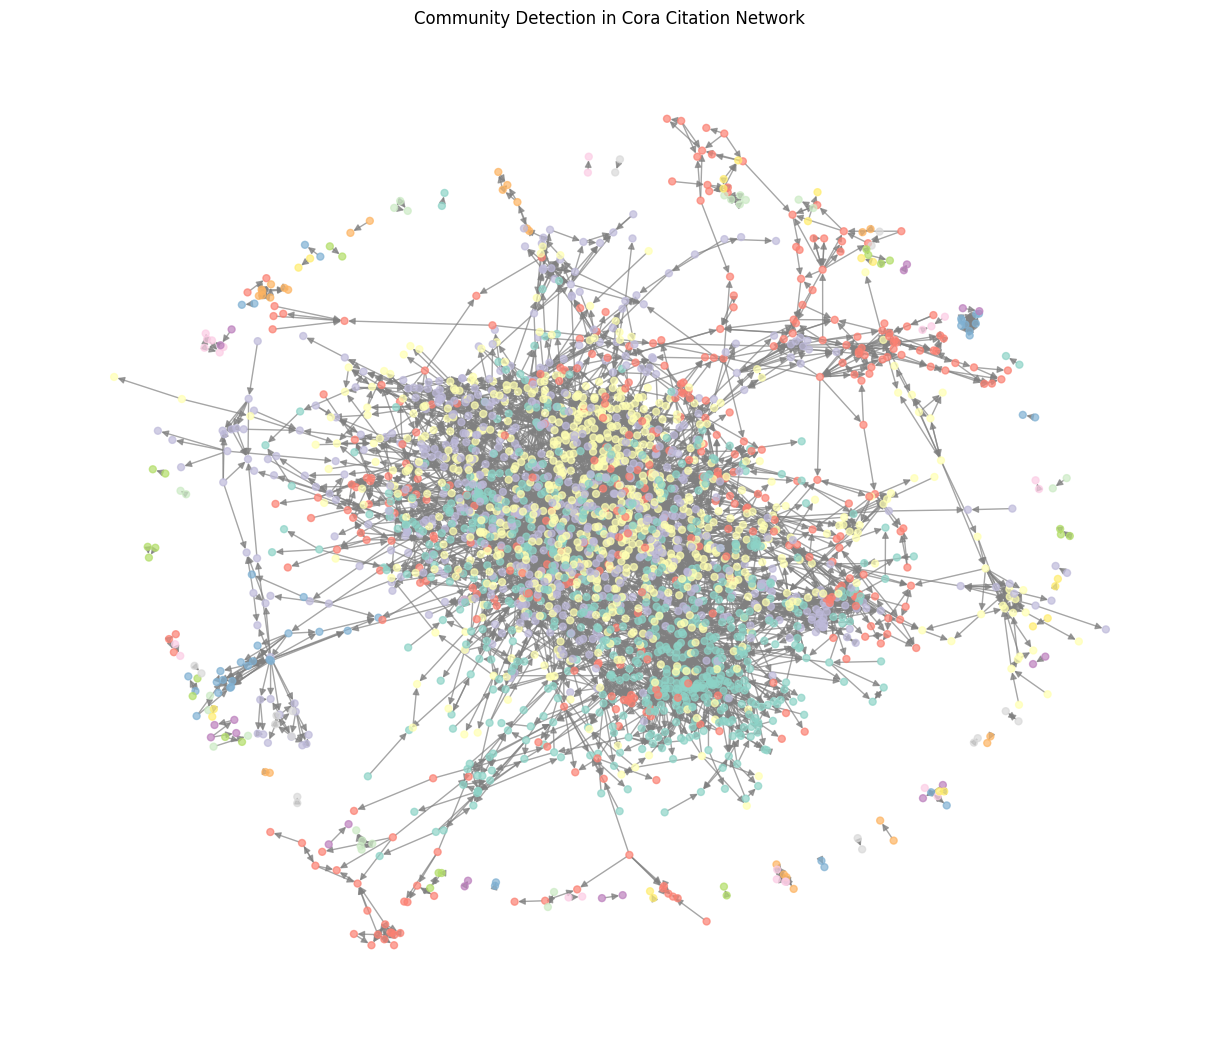

In [22]:
import community.community_louvain as community_louvain  # ✅ correct import
import networkx as nx
import matplotlib.pyplot as plt

partition = community_louvain.best_partition(G.to_undirected())
colors = [partition[n] for n in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=42),
    node_color=colors,
    cmap=plt.cm.Set3,
    node_size=25,
    edge_color="gray",
    alpha=0.7,
    with_labels=False
)
plt.title("Community Detection in Cora Citation Network")
plt.show()

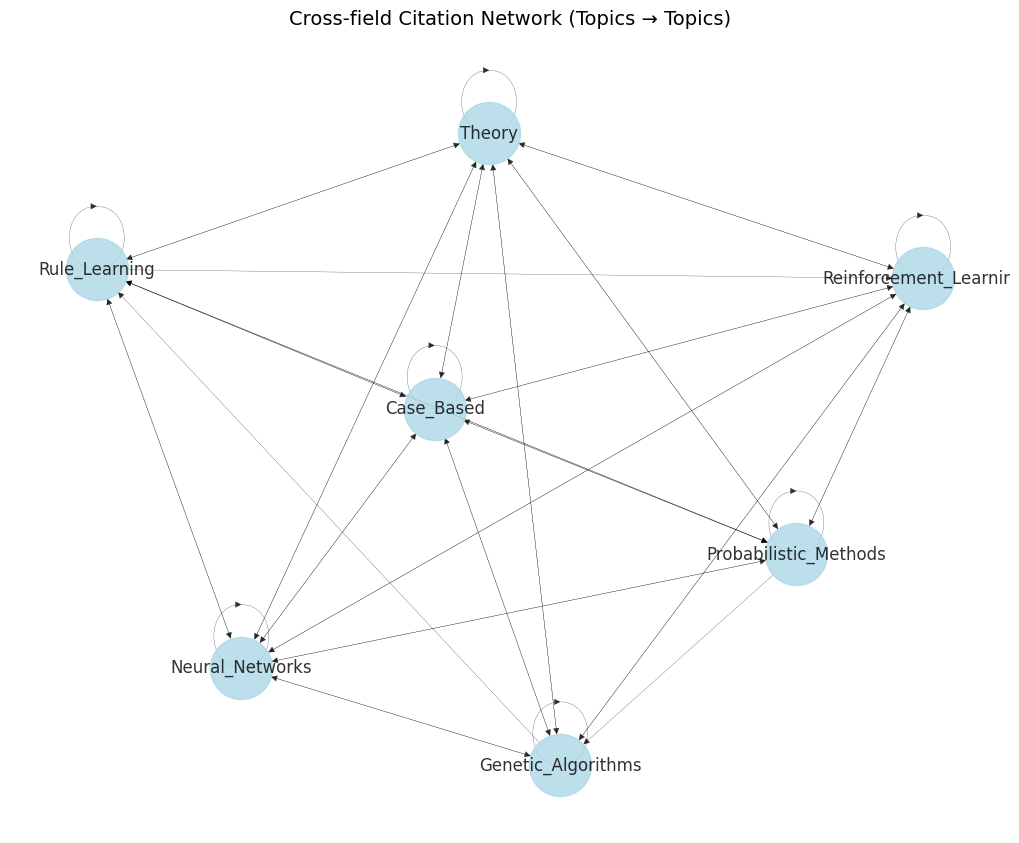

In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Create a mapping of paper_id → label
label_map = dict(zip(content[0], labels))

# Build field-level edges
field_edges = []
for src, tgt in edges.values:
    if src in label_map and tgt in label_map:
        src_label = label_map[src]
        tgt_label = label_map[tgt]
        field_edges.append((src_label, tgt_label))

# Create directed field-level graph
FG = nx.DiGraph()
FG.add_edges_from(field_edges)

# Aggregate edge weights (number of citations)
for u, v in FG.edges():
    FG[u][v]["weight"] = FG[u][v].get("weight", 0) + 1

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(FG, seed=42)
weights = [FG[u][v]["weight"] for u, v in FG.edges()]

nx.draw(FG, pos, with_labels=True, node_color="lightblue",
        node_size=2000, edge_color="black", width=[w/5 for w in weights], alpha=0.8)
plt.title("Cross-field Citation Network (Topics → Topics)", fontsize=14)
plt.show()

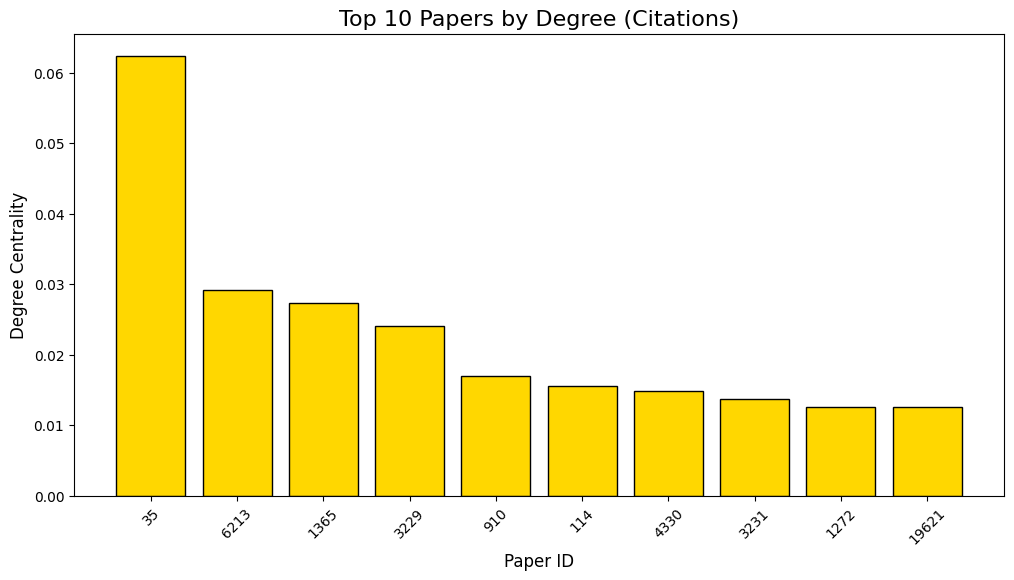


Description:
------------------------------------------------------------
Paper ID: 35 | Field: Genetic_Algorithms | Degree Centrality: 0.0624
Paper ID: 6213 | Field: Reinforcement_Learning | Degree Centrality: 0.0292
Paper ID: 1365 | Field: Neural_Networks | Degree Centrality: 0.0273
Paper ID: 3229 | Field: Neural_Networks | Degree Centrality: 0.0240
Paper ID: 910 | Field: Neural_Networks | Degree Centrality: 0.0170
Paper ID: 114 | Field: Reinforcement_Learning | Degree Centrality: 0.0155
Paper ID: 4330 | Field: Probabilistic_Methods | Degree Centrality: 0.0148
Paper ID: 3231 | Field: Theory | Degree Centrality: 0.0137
Paper ID: 1272 | Field: Theory | Degree Centrality: 0.0126
Paper ID: 19621 | Field: Neural_Networks | Degree Centrality: 0.0126


In [24]:
# Degree Centrality Analysis
degree_centrality = nx.degree_centrality(G)

# Get top 10 papers by degree
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot
plt.figure(figsize=(12,6))
plt.bar([str(n) for n, _ in top_degree],
        [v for _, v in top_degree],
        color='gold', edgecolor='black')
plt.title("Top 10 Papers by Degree (Citations)", fontsize=16)
plt.xlabel("Paper ID", fontsize=12)
plt.ylabel("Degree Centrality", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Print field info
print("\nDescription:")
print("-" * 60)
for paper_id, value in top_degree:
    field = content.loc[content[0] == paper_id, content.columns[-1]].values
    field = field[0] if len(field) > 0 else "Unknown"
    print(f"Paper ID: {paper_id} | Field: {field} | Degree Centrality: {value:.4f}")


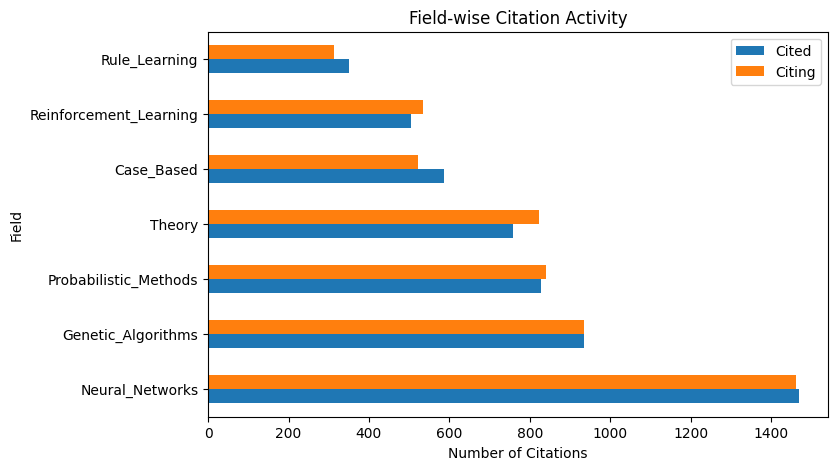

In [25]:
label_map = dict(zip(content[0], labels))

# Count citations per label
cited_count = {}
citing_count = {}
for src, tgt in edges.values:
    if src in label_map and tgt in label_map:
        citing = label_map[src]
        cited = label_map[tgt]
        cited_count[cited] = cited_count.get(cited, 0) + 1
        citing_count[citing] = citing_count.get(citing, 0) + 1

df_stats = pd.DataFrame({
    "Field": list(set(labels)),
    "Cited": [cited_count.get(f, 0) for f in set(labels)],
    "Citing": [citing_count.get(f, 0) for f in set(labels)]
})

df_stats.set_index("Field").sort_values("Cited", ascending=False).plot(kind="barh", figsize=(8,5))
plt.title("Field-wise Citation Activity")
plt.xlabel("Number of Citations")
plt.show()


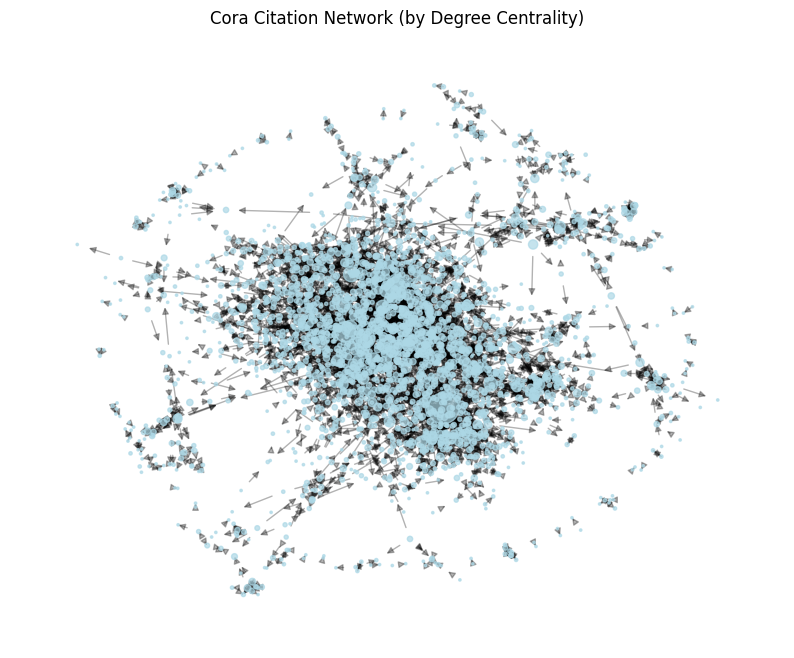

In [26]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes sized by degree
node_sizes = [v * 8000 for v in degree_centrality.values()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Cora Citation Network (by Degree Centrality)")
plt.axis("off")
plt.show()

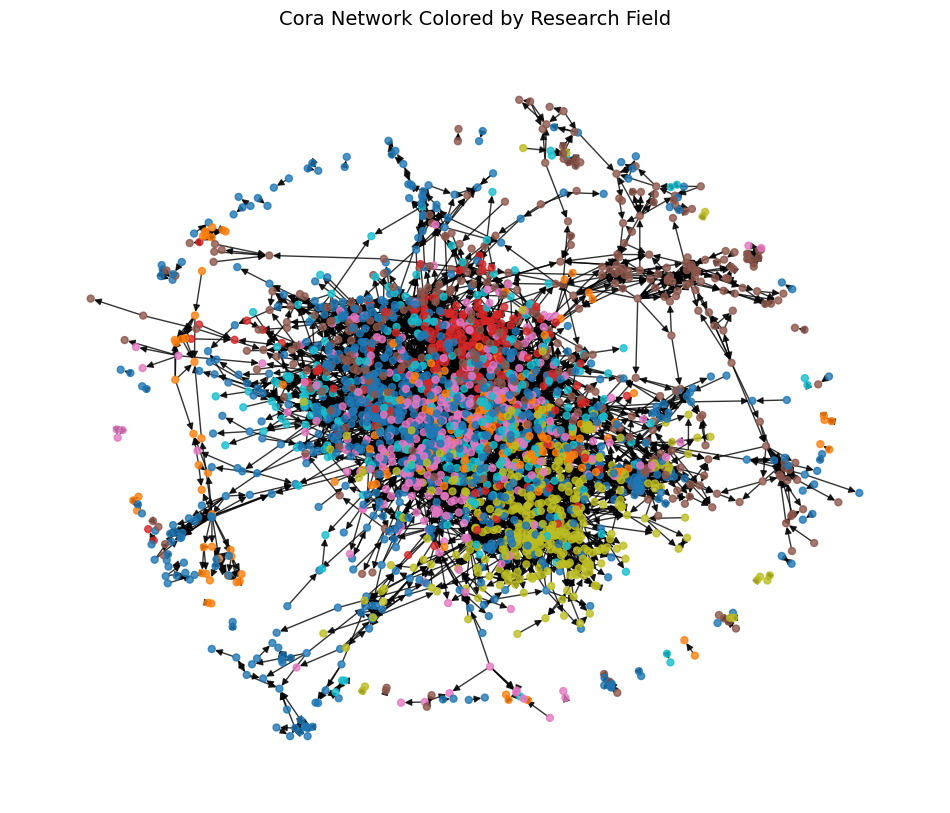

In [27]:
import numpy as np

# Map each label to a color
unique_labels = labels.unique()
label_to_color = {label: i for i, label in enumerate(unique_labels)}

node_colors = [label_to_color[labels[content[0] == n].values[0]]
               if n in paper_ids.values else 0 for n in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42),
                 node_color=node_colors, cmap=plt.cm.tab10,
                 node_size=25, alpha=0.8, with_labels=False)
plt.title("Cora Network Colored by Research Field", fontsize=14)
plt.axis("off")
plt.show()

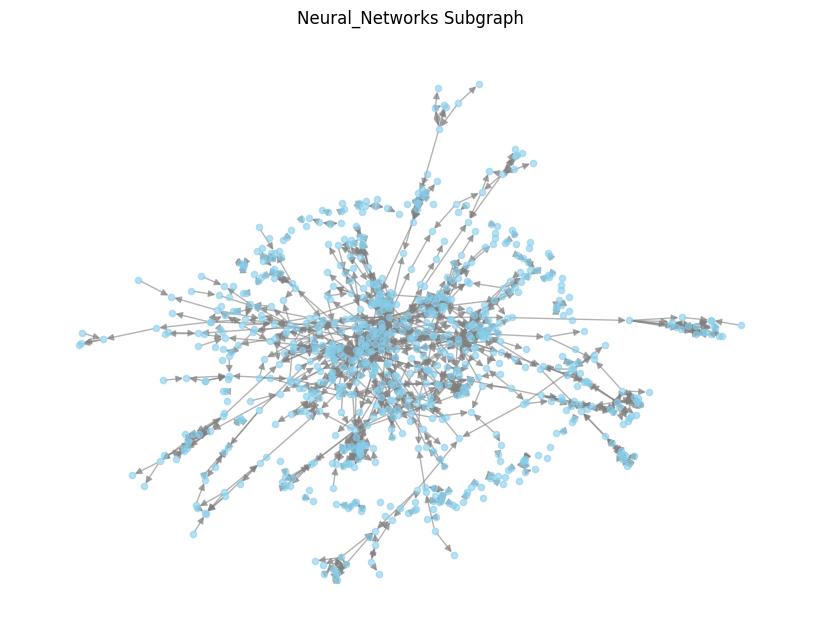

In [28]:
topic = "Neural_Networks"
nodes = content[content.iloc[:, -1] == topic][0].values
H = G.subgraph(nodes)

plt.figure(figsize=(8, 6))
nx.draw(H, node_size=20, node_color="skyblue", edge_color="gray", alpha=0.6)
plt.title(f"{topic} Subgraph")
plt.show()

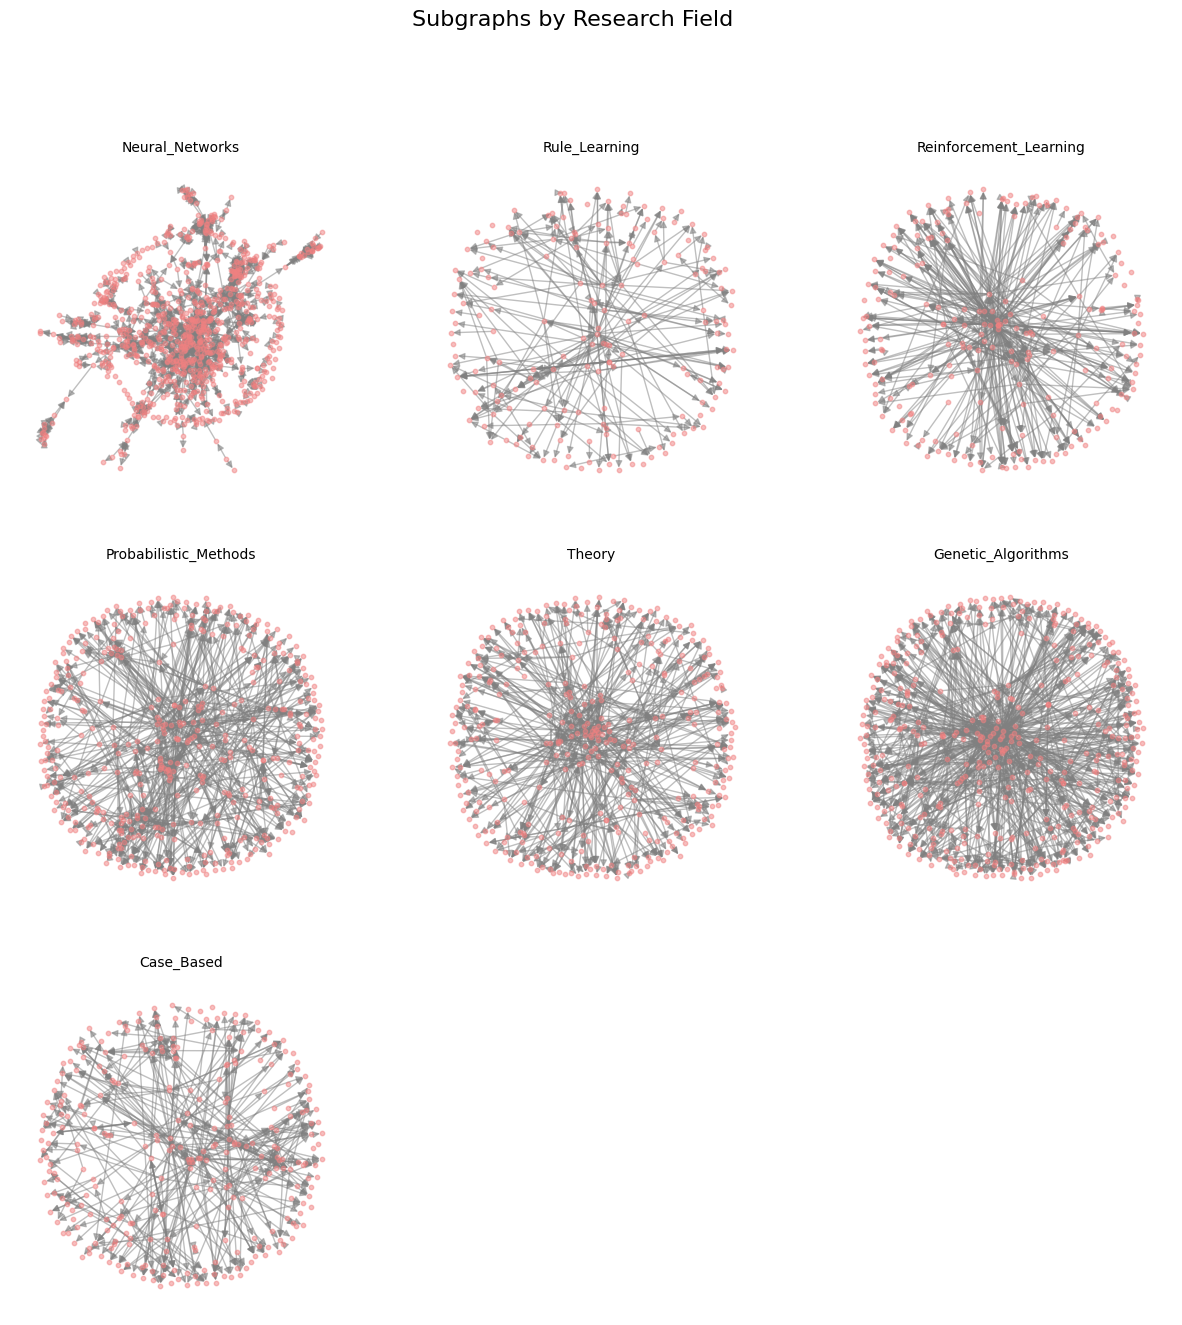

In [29]:
unique_labels = labels.unique()
plt.figure(figsize=(15, 15))

for i, label in enumerate(unique_labels[:9]):  # show top 9 fields
    nodes = content[content.iloc[:, -1] == label][0].values
    H = G.subgraph(nodes)
    plt.subplot(3, 3, i+1)
    pos = nx.spring_layout(H, seed=42)
    nx.draw(H, pos, node_size=10, node_color="lightcoral", edge_color="gray", alpha=0.5)
    plt.title(label, fontsize=10)
    plt.axis("off")

plt.suptitle("Subgraphs by Research Field", fontsize=16)
plt.show()

**3D interactive plots**

In [30]:
import plotly.graph_objects as go
import networkx as nx
import matplotlib.cm as cm
import numpy as np

# --- Compute 3D layout ---
pos = nx.spring_layout(G, dim=3, seed=42)

# --- Node positions ---
x_nodes = [pos[k][0] for k in G.nodes()]
y_nodes = [pos[k][1] for k in G.nodes()]
z_nodes = [pos[k][2] for k in G.nodes()]

# --- Edge coordinates ---
x_edges, y_edges, z_edges = [], [], []
for u, v in G.edges():
    x_edges += [pos[u][0], pos[v][0], None]
    y_edges += [pos[u][1], pos[v][1], None]
    z_edges += [pos[u][2], pos[v][2], None]

# --- Calculate degree/in-degree centrality ---
in_degree = dict(G.in_degree())
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_ids = [n for n, _ in top_nodes]

# --- Color and size setup ---
label_dict = dict(zip(paper_ids, labels))
unique_labels = labels.unique()
colors = cm.tab10(np.linspace(0, 1, len(unique_labels)))
color_map = {cls: f'rgb({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)})' for cls, c in zip(unique_labels, colors)}

node_colors = []
node_sizes = []
hover_texts = []

for n in G.nodes():
    field = label_dict.get(n, "Unknown")
    hover_text = f"Paper ID: {n}<br>Field: {field}<br>Citations: {in_degree.get(n,0)}"
    hover_texts.append(hover_text)
    
    if n in top_ids:
        node_colors.append("gold")  # highlight top papers
        node_sizes.append(10 + 20*(in_degree.get(n,0)/max(in_degree.values())))
    else:
        node_colors.append(color_map.get(field, "lightgray"))
        node_sizes.append(5 + 10*(in_degree.get(n,0)/max(in_degree.values())))

# --- Edge trace ---
edge_trace = go.Scatter3d(
    x=x_edges, y=y_edges, z=z_edges,
    mode='lines',
    line=dict(color='gray', width=1),
    hoverinfo='none'
)

# --- Node trace ---
node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=node_sizes, color=node_colors, opacity=1),
    text=hover_texts,
    hoverinfo='text'
)

# --- Legend workaround (Plotly doesn't support 3D scatter legend easily) ---
# Create two extra traces for legend
legend_traces = [
    go.Scatter3d(x=[None], y=[None], z=[None], mode='markers',
                 marker=dict(size=10, color='gold'), name='Top papers'),
    go.Scatter3d(x=[None], y=[None], z=[None], mode='markers',
                 marker=dict(size=5, color='skyblue'), name='Other Papers')
]
for f, color in color_map.items():
    legend_traces.append(
        go.Scatter3d(x=[None], y=[None], z=[None], mode='markers',
                     marker=dict(size=6, color=color), name=f)
    )

fig = go.Figure(data=[edge_trace, node_trace] + legend_traces)

# --- Layout ---
fig.update_layout(
    title='3D Cora Citation Graph — Top Papers Highlighted',
    showlegend=True,
    width=950, height=750,
    scene=dict(xaxis=dict(visible=False),
               yaxis=dict(visible=False),
               zaxis=dict(visible=False)),
    paper_bgcolor='white',
    scene_bgcolor='white',
    legend=dict(font=dict(color='black'))
)

# --- Save & show ---
fig.write_html("cora_3d_top_papers.html")
fig.show()

In [31]:
import plotly.graph_objects as go
import networkx as nx
import matplotlib.cm as cm
import numpy as np

# --- Prepare field-based centers ---
fields = labels.unique()
num_fields = len(fields)
field_idx = {f:i for i,f in enumerate(fields)}

# 3D centers arranged in a circle
radius = 2
theta = np.linspace(0, 2*np.pi, num_fields, endpoint=False)
field_centers = {f:(radius*np.cos(t), radius*np.sin(t), 0) for f, t in zip(fields, theta)}

# --- Node positions with jitter around field centers ---
pos = {}
label_dict = dict(zip(paper_ids, labels))
for n in G.nodes():
    f = label_dict.get(n, "Unknown")
    cx, cy, cz = field_centers.get(f, (0,0,0))
    jitter = np.random.uniform(-0.3, 0.3, 3)  # small random offset
    pos[n] = (cx + jitter[0], cy + jitter[1], cz + jitter[2])

# --- Extract node coordinates ---
x_nodes = [pos[k][0] for k in G.nodes()]
y_nodes = [pos[k][1] for k in G.nodes()]
z_nodes = [pos[k][2] for k in G.nodes()]

# --- Edge coordinates ---
x_edges, y_edges, z_edges = [], [], []
for u, v in G.edges():
    x_edges += [pos[u][0], pos[v][0], None]
    y_edges += [pos[u][1], pos[v][1], None]
    z_edges += [pos[u][2], pos[v][2], None]

# --- Degree centrality & top papers ---
in_degree = dict(G.in_degree())
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_ids = [n for n, _ in top_nodes]

# --- Node colors & sizes ---
colors = cm.tab10(np.linspace(0,1,num_fields))
color_map = {f: f'rgb({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)})' for f,c in zip(fields, colors)}

node_colors = []
node_sizes = []
hover_texts = []

for n in G.nodes():
    field = label_dict.get(n, "Unknown")
    hover_texts.append(f"Paper ID: {n}<br>Field: {field}<br>Citations: {in_degree.get(n,0)}")
    if n in top_ids:
        node_colors.append("gold")
        node_sizes.append(10 + 20*(in_degree.get(n,0)/max(in_degree.values())))
    else:
        node_colors.append(color_map.get(field, "lightgray"))
        node_sizes.append(5 + 10*(in_degree.get(n,0)/max(in_degree.values())))

# --- Edge trace ---
edge_trace = go.Scatter3d(
    x=x_edges, y=y_edges, z=z_edges,
    mode='lines', line=dict(color='black', width=1), hoverinfo='none'
)

# --- Node trace ---
node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=node_sizes, color=node_colors, opacity=1),
    text=hover_texts,
    hoverinfo='text'
)

# --- Legend ---
legend_traces = [
    go.Scatter3d(x=[None], y=[None], z=[None], mode='markers',
                 marker=dict(size=10, color='black'), name='Top Papers')
]
for f, color in color_map.items():
    legend_traces.append(
        go.Scatter3d(x=[None], y=[None], z=[None], mode='markers',
                     marker=dict(size=6, color=color), name=f)
    )

# --- Figure ---
fig = go.Figure(data=[edge_trace, node_trace]+legend_traces)
fig.update_layout(
    title="3D Cora Citation Graph — Papers Clustered by Field",
    showlegend=True,
    width=950, height=750,
    scene=dict(xaxis=dict(visible=False),
               yaxis=dict(visible=False),
               zaxis=dict(visible=False)),
    paper_bgcolor='white',
    scene_bgcolor='white',
    legend=dict(font=dict(color='black'))
)

fig.show()


In [32]:
!pip install pyvis